In [1]:
import torch
from transformers import BertForMaskedLM, BertTokenizerFast
from finetune_vs_scratch.model import load_model_and_tokenizer
model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model, tokenizer = load_model_and_tokenizer(model_name, 1, "cpu")

del model 


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [3]:
from glob import glob

num_files = 100
tweet_files = glob("../data/spanish_tweets/*.txt")[:1]

In [4]:
%%time
from datasets import load_dataset, Features, Value


features = Features({
    'text': Value('string'),
})

"""
train_dataset, test_dataset = load_dataset(
    "text", data_files={"train": train_files, "test": dev_files}, split=["train", "test"], features=features
)
"""

dataset = load_dataset(
    "text", data_files=tweet_files, features=features
)

train_dataset = dataset["train"]


Using custom data configuration default-8cc70ee41bb2c24e


0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /home/jmperez/.cache/huggingface/datasets/text/default-8cc70ee41bb2c24e/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.
CPU times: user 4.3 s, sys: 1.88 s, total: 6.17 s
Wall time: 7.5 s


In [5]:
len(train_dataset)

3188797

In [19]:
dataset = train_dataset.select(range(200_000))

In [20]:
import re
from finetune_vs_scratch.preprocessing import preprocess


tw = preprocess("⛳⛳tugobierrr⛳")


re.sub("emoji.*?emoji", "emoji", tw)

'emoji emoji tugobierrr emoji'

In [21]:

tokenizer("emoji")

{'input_ids': [4, 31005, 5], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [22]:
def tokenize(batch):
    text = [re.sub("emoji.*?emoji", "emoji", tw) for tw in batch['text']]
    return tokenizer(text, padding='max_length', truncation=True)

batch_size = 32

#train_dataset.set_transform(tokenize)
dataset = dataset.map(tokenize, batched=True, batch_size=batch_size)
#test_dataset = test_dataset.map(tokenize, batched=True, batch_size=batch_size)


  0%|          | 0/6250 [00:00<?, ?ba/s]

In [25]:
from tqdm.auto import tqdm
lens = []
for i in tqdm(range(len(dataset))):
    lens.append(sum(dataset[i]["attention_mask"]) - 2)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [26]:
import numpy as np

lens = np.array(lens)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(array([1.000e+00, 2.058e+03, 5.298e+03, 5.563e+03, 6.798e+03, 7.562e+03,
        8.160e+03, 8.513e+03, 8.198e+03, 7.993e+03, 7.580e+03, 7.450e+03,
        7.056e+03, 6.413e+03, 6.329e+03, 5.881e+03, 5.497e+03, 5.647e+03,
        4.664e+03, 4.617e+03, 4.072e+03, 3.946e+03, 3.633e+03, 3.390e+03,
        3.149e+03, 2.994e+03, 2.936e+03, 2.868e+03, 2.601e+03, 2.404e+03,
        2.380e+03, 2.171e+03, 2.208e+03, 2.021e+03, 1.782e+03, 1.818e+03,
        1.729e+03, 1.611e+03, 1.559e+03, 2.885e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40.]),
 <BarContainer object of 40 artists>)

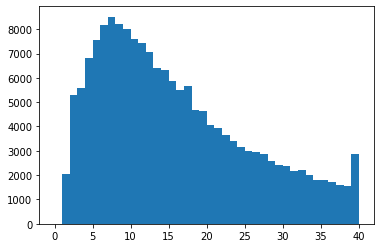

In [27]:

import matplotlib.pyplot as plt
import numpy as np

plt.hist(lens, range=[0, 40], bins=40)

In [31]:

basuras = dataset.select(np.argwhere(lens <= 5).reshape(-1))["text"]


len(basuras) / len(dataset)

0.1364

(array([1.45000e+02, 8.72270e+04, 1.18424e+05, 1.34795e+05, 1.70053e+05,
        1.86960e+05, 2.06024e+05, 2.11339e+05, 2.05746e+05, 2.05715e+05,
        1.97759e+05, 1.92563e+05, 1.82300e+05, 1.77291e+05, 1.65679e+05,
        1.57021e+05, 1.51523e+05, 1.44747e+05, 1.32239e+05, 1.30689e+05,
        1.19057e+05, 1.11476e+05, 1.05311e+05, 9.91010e+04, 9.25650e+04,
        9.11660e+04, 8.22480e+04, 7.76120e+04, 7.59960e+04, 6.89320e+04,
        6.48930e+04, 6.19600e+04, 5.94000e+04, 5.19770e+04, 4.86470e+04,
        4.53600e+04, 4.22300e+04, 3.90980e+04, 3.77490e+04, 6.66770e+04]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40.]),
 <BarContainer object of 40 artists>)

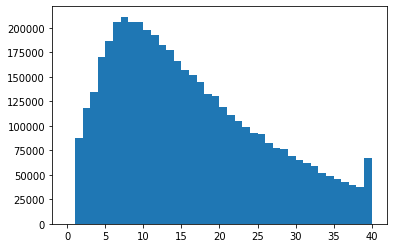

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(lens, range=[0, 40], bins=40)

Parece algo razonable quedarme sólo con los que tienen 

In [79]:
basuras = train_dataset.select(np.argwhere(lens <= 5).reshape(-1))["text"]


len(basuras) / len(train_dataset)

0.13168988719587474

In [78]:
import random


random.sample(basuras, 10)

['@usuario URL',
 'URL',
 '@usuario Fugaaa',
 'Q asco tengo',
 '@usuario Jjaja amo.',
 'Linda nightt',
 'URL URL',
 'Poder dormir buena siesta es lava',
 'Jjaja URL',
 'URL']

In [74]:
border = train_dataset.select(np.argwhere(lens == 6).reshape(-1))["text"]

random.sample(border, 10)

['PROD SUGAAA URL',
 '@usuario hijo tuyo parece jaja',
 'I want to know',
 'Que ganas de una mccc',
 'Acaba de publicar una foto URL',
 '@usuario Vosotros seguid URL peña.',
 'Me voy a dormir yf',
 'Atajo atajo atajooo el penal',
 'Que cosa linda los días así',
 '@usuario Jjaja hdp']

In [80]:
random.sample(border, 10)

['Aca tambien porque me encantan URL',
 '@usuario c ve con madre!',
 'Ni me enteré que es domingo',
 'Puedes hacer lo que quieras conmigo',
 'Vienen cosas nuevas y mejores.',
 'Que triste me pone extrañar tanto',
 'hashtag rap mexicano B| ♫',
 '@usuario is ugly.',
 '¡Me encantas! URL',
 '@usuario Más vale que si Florencia']

Me parece que quedarnos con los que tienen 6 o más tokens está bien